# DIY Interactive Segmentation with napari

+++

napari is a very flexible and "hackable" tool. In this tutorial we will
make a custom interactive segmentation tool from scratch.

+++

In this tutorial we will write an interactive segmentation tool

In [1]:
from appdirs import user_data_dir
import os
import zarr
import dask.array as da
import toolz as tz

from sklearn.ensemble import RandomForestClassifier

from skimage import data, segmentation, feature, future
from skimage.feature import multiscale_basic_features
from skimage.io import imread, imshow
import numpy as np
from functools import partial
import napari
import threading

from ome_zarr.io import parse_url
from ome_zarr.reader import Reader

from functools import partial
from psygnal import debounced
from superqt import ensure_main_thread

import logging
import sys

LOGGER = logging.getLogger("halfway_to_i2k_2023_america")
LOGGER.setLevel(logging.DEBUG)

streamHandler = logging.StreamHandler(sys.stdout)
formatter = logging.Formatter(
    "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)
streamHandler.setFormatter(formatter)
LOGGER.addHandler(streamHandler)

# Open the data

For simplicity we will just use the first channel

In [34]:

image = imread("../../data/16_06_21_10E5b_P6210591_000.jpg")
image = image[:,:,0]

image = imread("../../data/IXMtest_A02_s9.tif")
image = image[:,:,0]  
prediction_name = "prediction_nuclei"
painting_name = "painting_nuclei"

image = imread("../../data/bees1.tif")
prediction_name = "prediction_bees"
painting_name = "painting_bees"

image = imread("../../data/bees2.tif")
prediction_name = "prediction_bees2"
painting_name = "painting_bees2"

image = imread("../../data/sem.tif")
prediction_name = "prediction_sem"
painting_name = "painting_sem"

### Visualize in Napari

In [35]:
viewer = napari.Viewer()

data_layer = viewer.add_image(image)
data_layer.bounding_box.visible = True

### Extract Features

In [36]:
def extract_features(image, feature_params):
    features_func = partial(
        multiscale_basic_features,
        intensity=feature_params["intensity"],
        edges=feature_params["edges"],
        texture=feature_params["texture"],
        sigma_min=feature_params["sigma_min"],
        sigma_max=feature_params["sigma_max"],
        channel_axis=None,
    )
    # print(f"image shape {image.shape} feature params {feature_params}")
    features = features_func(np.squeeze(image))
    return features

example_feature_params = {
    "sigma_min": 1,
    "sigma_max": 5,
    "intensity": True,
    "edges": True,
    "texture": True,
}

features = extract_features(image, example_feature_params)
features.shape

(1024, 1536, 12)

### Visualize Features

In [5]:
def show_features():
    for feature_idx in range(features.shape[-1]):
        viewer.add_image(features[:, :, feature_idx])
        
show_features()

### Making the Interactive Segmentation Tool!

Ok, now we've seen:
- our data
- some features we can compute for our data

Our goal is to create an image where we have labels that correspond to the zebrafish sample. 

The approach is that when we annotate/draw in our painting layer, then we want our segmentations to be updated automatically. 

We will do this using 3 different image layers:

1. Our input image
2. A layer for painting
3. A layer for storing the machine learning generated predictions

Due to popular demand we will be using Zarr to store these layers, because that will help this approach scale to very large datasets. However, we could have used numpy arrays as well.

+++

### Create our painting and prediction layers


In [37]:
zarr_path = r"../../data/temp"
print(f"Saving outputs to zarr path: {zarr_path}")

# Create a prediction layer
prediction_data = zarr.open(
    f"{zarr_path}/{prediction_name}",
    mode='a',
    shape=image.shape,
    dtype='i4',
    dimension_separator="/",

)
prediction_layer = viewer.add_labels(prediction_data, name="Prediction", scale=data_layer.scale)

# Create a painting layer
painting_data = zarr.open(
    f"{zarr_path}/{painting_name}",
    mode='a',
    shape=image.shape,
    dtype='i4',
    dimension_separator="/",
)
painting_layer = viewer.add_labels(painting_data, name="Painting", scale=data_layer.scale)

Saving outputs to zarr path: ../../data/temp


### Let's make a UI as well

In [38]:
from qtpy.QtWidgets import (
    QVBoxLayout,
    QHBoxLayout,
    QComboBox,
    QLabel,
    QCheckBox,
    QDoubleSpinBox,
    QGroupBox,
    QWidget,
)

class NapariMLWidget(QWidget):
    def __init__(self, parent=None):
        super(NapariMLWidget, self).__init__(parent)

        self.initUI()

    def initUI(self):
        layout = QVBoxLayout()

        # Dropdown for selecting the model
        model_label = QLabel("Select Model")
        self.model_dropdown = QComboBox()
        self.model_dropdown.addItems(["Random Forest"])
        model_layout = QHBoxLayout()
        model_layout.addWidget(model_label)
        model_layout.addWidget(self.model_dropdown)
        layout.addLayout(model_layout)

        # Select the range of sigma sizes
        self.sigma_start_spinbox = QDoubleSpinBox()
        self.sigma_start_spinbox.setRange(0, 256)
        self.sigma_start_spinbox.setValue(1)

        self.sigma_end_spinbox = QDoubleSpinBox()
        self.sigma_end_spinbox.setRange(0, 256)
        self.sigma_end_spinbox.setValue(5)

        sigma_layout = QHBoxLayout()
        sigma_layout.addWidget(QLabel("Sigma Range: From"))
        sigma_layout.addWidget(self.sigma_start_spinbox)
        sigma_layout.addWidget(QLabel("To"))
        sigma_layout.addWidget(self.sigma_end_spinbox)
        layout.addLayout(sigma_layout)

        # Boolean options for features
        self.intensity_checkbox = QCheckBox("Intensity")
        self.intensity_checkbox.setChecked(True)
        self.edges_checkbox = QCheckBox("Edges")
        self.texture_checkbox = QCheckBox("Texture")
        self.texture_checkbox.setChecked(True)

        features_group = QGroupBox("Features")
        features_layout = QVBoxLayout()
        features_layout.addWidget(self.intensity_checkbox)
        features_layout.addWidget(self.edges_checkbox)
        features_layout.addWidget(self.texture_checkbox)
        features_group.setLayout(features_layout)
        layout.addWidget(features_group)

        # Dropdown for data selection
        data_label = QLabel("Select Data for Model Fitting")
        self.data_dropdown = QComboBox()
        self.data_dropdown.addItems(
            ["Current Displayed Region", "Whole Image"]
        )
        self.data_dropdown.setCurrentText("Current Displayed Region")
        data_layout = QHBoxLayout()
        data_layout.addWidget(data_label)
        data_layout.addWidget(self.data_dropdown)
        layout.addLayout(data_layout)

        # Checkbox for live model fitting
        self.live_fit_checkbox = QCheckBox("Live Model Fitting")
        self.live_fit_checkbox.setChecked(True)
        layout.addWidget(self.live_fit_checkbox)

        # Checkbox for live prediction
        self.live_pred_checkbox = QCheckBox("Live Prediction")
        self.live_pred_checkbox.setChecked(True)
        layout.addWidget(self.live_pred_checkbox)

        self.setLayout(layout)
        

In [39]:
# Let's add this widget to napari

widget = NapariMLWidget()
viewer.window.add_dock_widget(widget, name="halfway to I2K 2023 America")

### We have a widget, we have our painting and prediction layers, now what?

We need to start connecting things together. How should we do that? napari has things called "events" that happen when things happen within napari. We want to respond to a few different event types:
- changes in camera (e.g. camera position and rotation)
- changes in "dims" (e.g. moving a dimension slider)
- painting events (e.g. a user clicked, painted, and release their mouse)

When one of these events happens, we want to: 
- update our machine learning model with the new painted data
- update our prediction with the updated ML model


In [40]:
# Let's start with our event listener

# We use "curry" because this allows us to "store" our viewer and widget for later use
@tz.curry
def on_data_change(event, viewer=None, widget=None):
    corner_pixels = data_layer.corner_pixels

    # Ensure the painting layer visual is updated
    painting_layer.refresh()

    # Training the ML model and generating predictions can take time
    #   we will use a "thread" to perform these calculations
    #   otherwise napari will freeze until these
    # calculations are done
    thread = threading.Thread(
        target=threaded_on_data_change,
        args=(
            event,
            corner_pixels,
            viewer.dims,
            widget.model_dropdown.currentText(),
            {
                "sigma_min": widget.sigma_start_spinbox.value(),
                "sigma_max": widget.sigma_end_spinbox.value(),
                "intensity": widget.intensity_checkbox.isChecked(),
                "edges": widget.edges_checkbox.isChecked(),
                "texture": widget.texture_checkbox.isChecked(),
            },
            widget.live_fit_checkbox.isChecked(),
            widget.live_pred_checkbox.isChecked(),
            widget.data_dropdown.currentText(),
        ),
    )
    thread.start()
    thread.join()

    # Ensure the prediction layer visual is updated
    prediction_layer.refresh()

In [41]:
# Now we have to make the hard part of the listener

model = None

def threaded_on_data_change(
    event,
    corner_pixels,
    dims,
    model_type,
    feature_params,
    live_fit,
    live_prediction,
    data_choice,
):
    global model
    LOGGER.info(f"Labels data has changed! {event}")

    current_step = dims.current_step

    LOGGER.info("make mask")
    # Find a mask of indices we will use for fetching our data
    mask_idx = (slice(corner_pixels[0, 0], corner_pixels[1, 0]), slice(corner_pixels[0, 1], corner_pixels[1, 1]))
    #if data_choice == "Whole Image":
    #    mask_idx = tuple([slice(0, sz) for sz in data_layer.data.shape])

    LOGGER.info(f"mask idx {mask_idx}, image {data_layer.data.shape}")
    active_image = data_layer.data[mask_idx]
    LOGGER.info(
        f"active image shape {active_image.shape} data choice {data_choice} painting_data {painting_data.shape} mask_idx {mask_idx}"
    )

    active_labels = painting_data[mask_idx]

    def compute_features(image, feature_params):
        """Compute features for each channel and concatenate them."""
        features = extract_features(
            image, feature_params
        )

        return features

    training_labels = None

    if data_choice == "Current Displayed Region":
        # Use only the currently displayed region.
        training_features = compute_features(
            active_image, feature_params
        )
        training_labels = np.squeeze(active_labels)

    else:
        raise ValueError(f"Invalid data choice: {data_choice}")

    if (training_labels is None) or np.any(training_labels.shape == 0):
        LOGGER.info("No training data yet. Skipping model update")
    elif live_fit:
        # Retrain model
        LOGGER.info(
            f"training model with labels {training_labels.shape} features {training_features.shape} unique labels {np.unique(training_labels[:])}"
        )
        model = update_model(training_labels, training_features, model_type)

    # Don't do live prediction on whole image, that happens earlier slicewise
    if live_prediction:
        # Update prediction_data
        prediction_features = compute_features(
            active_image, feature_params
        )
        # Add 1 becasue of the background label adjustment for the model
        prediction = predict(model, prediction_features, model_type)
        LOGGER.info(
            f"prediction {prediction.shape} prediction layer {prediction_layer.data.shape} prediction {np.transpose(prediction).shape} features {prediction_features.shape}"
        )

        #if data_choice == "Whole Image":
        prediction_layer.data[mask_idx] = np.transpose(prediction)
        #else:
        #    prediction_layer.data[mask_idx] = np.transpose(prediction)[
        #        np.newaxis, :
        #    ]

In [42]:
# Model training function that respects widget's model choice
def update_model(labels, features, model_type):
    features = features[labels > 0, :]
    # We shift labels - 1 because background is 0 and has special meaning, but models need to start at 0
    labels = labels[labels > 0] - 1
    
    if model_type == "Random Forest":
        clf = RandomForestClassifier(
            n_estimators=50, n_jobs=-1, max_depth=10, max_samples=0.05
        )

    print(
        f"updating model with label shape  {labels.shape} feature shape {features.shape} unique labels {np.unique(labels)}"
    )
    
    clf.fit(features, labels)

    return clf


def predict(model, features, model_type):
    # We shift labels + 1 because background is 0 and has special meaning
    prediction = future.predict_segmenter(features.reshape(-1, features.shape[-1]), model).reshape(features.shape[:-1]) + 1

    return np.transpose(prediction)

In [ ]:
# Now connect everything together
for listener in [
    viewer.camera.events,
    viewer.dims.events,
    painting_layer.events.paint,
]:
    listener.connect(
        debounced(
            ensure_main_thread(
                on_data_change(
                    viewer=viewer,
                    widget=widget,  # pass the widget instance for easy access to settings
                )
            ),
            timeout=1000,
        )
    )

2024-03-05 14:49:27,851 - halfway_to_i2k_2023_america - INFO - Labels data has changed! Event
2024-03-05 14:49:27,856 - halfway_to_i2k_2023_america - INFO - make mask
2024-03-05 14:49:27,858 - halfway_to_i2k_2023_america - INFO - mask idx (slice(379, 609, None), slice(690, 937, None)), image (1024, 1536)
2024-03-05 14:49:27,859 - halfway_to_i2k_2023_america - INFO - active image shape (230, 247) data choice Current Displayed Region painting_data (1024, 1536) mask_idx (slice(379, 609, None), slice(690, 937, None))
2024-03-05 14:49:27,883 - halfway_to_i2k_2023_america - INFO - training model with labels (230, 247) features (230, 247, 9) unique labels [0]


Exception in thread Thread-1659:
Traceback (most recent call last):
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\bnort\AppData\Local\Temp\ipykernel_11572\2642771022.py", line 61, in threaded_on_data_change
  File "C:\Users\bnort\AppData\Local\Temp\ipykernel_11572\1753605063.py", line 16, in update_model
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\site-packages\sklearn\ensemble\_forest.py", line 348, in fit
    X, y = self._validate_data(
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\site-packages\sklearn\base.py", line 621, in _validate_data
    X, y = ch

updating model with label shape  (0,) feature shape (0, 9) unique labels []
2024-03-05 14:49:36,353 - halfway_to_i2k_2023_america - INFO - Labels data has changed! Event
2024-03-05 14:49:36,357 - halfway_to_i2k_2023_america - INFO - make mask
2024-03-05 14:49:36,358 - halfway_to_i2k_2023_america - INFO - mask idx (slice(379, 609, None), slice(690, 937, None)), image (1024, 1536)
2024-03-05 14:49:36,359 - halfway_to_i2k_2023_america - INFO - active image shape (230, 247) data choice Current Displayed Region painting_data (1024, 1536) mask_idx (slice(379, 609, None), slice(690, 937, None))
2024-03-05 14:49:36,386 - halfway_to_i2k_2023_america - INFO - training model with labels (230, 247) features (230, 247, 9) unique labels [0]


Exception in thread Thread-1662:
Traceback (most recent call last):
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\bnort\AppData\Local\Temp\ipykernel_11572\2642771022.py", line 61, in threaded_on_data_change
  File "C:\Users\bnort\AppData\Local\Temp\ipykernel_11572\1753605063.py", line 16, in update_model
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\site-packages\sklearn\ensemble\_forest.py", line 348, in fit
    X, y = self._validate_data(
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\site-packages\sklearn\base.py", line 621, in _validate_data
    X, y = ch

updating model with label shape  (0,) feature shape (0, 9) unique labels []
2024-03-05 14:49:43,805 - halfway_to_i2k_2023_america - INFO - Labels data has changed! Event
2024-03-05 14:49:43,809 - halfway_to_i2k_2023_america - INFO - make mask
2024-03-05 14:49:43,810 - halfway_to_i2k_2023_america - INFO - mask idx (slice(379, 609, None), slice(690, 937, None)), image (1024, 1536)
2024-03-05 14:49:43,811 - halfway_to_i2k_2023_america - INFO - active image shape (230, 247) data choice Current Displayed Region painting_data (1024, 1536) mask_idx (slice(379, 609, None), slice(690, 937, None))
2024-03-05 14:49:43,837 - halfway_to_i2k_2023_america - INFO - training model with labels (230, 247) features (230, 247, 9) unique labels [0 1]
updating model with label shape  (32,) feature shape (32, 9) unique labels [0]
2024-03-05 14:49:44,055 - halfway_to_i2k_2023_america - INFO - prediction (247, 230) prediction layer (1024, 1536) prediction (230, 247) features (230, 247, 9)
2024-03-05 14:49:57,09

Exception in thread Thread-2530:
Traceback (most recent call last):
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\bnort\AppData\Local\Temp\ipykernel_11572\2642771022.py", line 61, in threaded_on_data_change
  File "C:\Users\bnort\AppData\Local\Temp\ipykernel_11572\1753605063.py", line 16, in update_model
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\site-packages\sklearn\ensemble\_forest.py", line 348, in fit
    X, y = self._validate_data(
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\site-packages\sklearn\base.py", line 621, in _validate_data
    X, y = ch

updating model with label shape  (0,) feature shape (0, 9) unique labels []
2024-03-05 14:52:43,600 - halfway_to_i2k_2023_america - INFO - Labels data has changed! Event
2024-03-05 14:52:43,605 - halfway_to_i2k_2023_america - INFO - make mask
2024-03-05 14:52:43,607 - halfway_to_i2k_2023_america - INFO - mask idx (slice(586, 816, None), slice(458, 705, None)), image (1024, 1536)
2024-03-05 14:52:43,608 - halfway_to_i2k_2023_america - INFO - active image shape (230, 247) data choice Current Displayed Region painting_data (1024, 1536) mask_idx (slice(586, 816, None), slice(458, 705, None))
2024-03-05 14:52:43,634 - halfway_to_i2k_2023_america - INFO - training model with labels (230, 247) features (230, 247, 9) unique labels [0 1]
updating model with label shape  (156,) feature shape (156, 9) unique labels [0]
2024-03-05 14:52:43,913 - halfway_to_i2k_2023_america - INFO - prediction (247, 230) prediction layer (1024, 1536) prediction (230, 247) features (230, 247, 9)
2024-03-05 14:52:43,

Exception in thread Thread-3258:
Traceback (most recent call last):
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\bnort\AppData\Local\Temp\ipykernel_11572\2642771022.py", line 52, in threaded_on_data_change
ValueError: Invalid data choice: Whole Image


2024-03-05 14:54:39,101 - halfway_to_i2k_2023_america - INFO - Labels data has changed! Event
2024-03-05 14:54:39,106 - halfway_to_i2k_2023_america - INFO - make mask
2024-03-05 14:54:39,108 - halfway_to_i2k_2023_america - INFO - mask idx (slice(605, 792, None), slice(636, 837, None)), image (1024, 1536)
2024-03-05 14:54:39,109 - halfway_to_i2k_2023_america - INFO - active image shape (187, 201) data choice Whole Image painting_data (1024, 1536) mask_idx (slice(605, 792, None), slice(636, 837, None))


Exception in thread Thread-3261:
Traceback (most recent call last):
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\bnort\AppData\Local\Temp\ipykernel_11572\2642771022.py", line 52, in threaded_on_data_change
ValueError: Invalid data choice: Whole Image


2024-03-05 14:54:44,319 - halfway_to_i2k_2023_america - INFO - Labels data has changed! Event
2024-03-05 14:54:44,324 - halfway_to_i2k_2023_america - INFO - make mask
2024-03-05 14:54:44,326 - halfway_to_i2k_2023_america - INFO - mask idx (slice(605, 792, None), slice(636, 837, None)), image (1024, 1536)
2024-03-05 14:54:44,327 - halfway_to_i2k_2023_america - INFO - active image shape (187, 201) data choice Whole Image painting_data (1024, 1536) mask_idx (slice(605, 792, None), slice(636, 837, None))


Exception in thread Thread-3264:
Traceback (most recent call last):
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\bnort\AppData\Local\Temp\ipykernel_11572\2642771022.py", line 52, in threaded_on_data_change
ValueError: Invalid data choice: Whole Image


2024-03-05 14:54:46,303 - halfway_to_i2k_2023_america - INFO - Labels data has changed! Event
2024-03-05 14:54:46,309 - halfway_to_i2k_2023_america - INFO - make mask
2024-03-05 14:54:46,310 - halfway_to_i2k_2023_america - INFO - mask idx (slice(504, 934, None), slice(432, 893, None)), image (1024, 1536)
2024-03-05 14:54:46,312 - halfway_to_i2k_2023_america - INFO - active image shape (430, 461) data choice Whole Image painting_data (1024, 1536) mask_idx (slice(504, 934, None), slice(432, 893, None))


Exception in thread Thread-3274:
Traceback (most recent call last):
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\bnort\AppData\Local\Temp\ipykernel_11572\2642771022.py", line 52, in threaded_on_data_change
ValueError: Invalid data choice: Whole Image


2024-03-05 14:54:47,706 - halfway_to_i2k_2023_america - INFO - Labels data has changed! Event
2024-03-05 14:54:47,711 - halfway_to_i2k_2023_america - INFO - make mask
2024-03-05 14:54:47,713 - halfway_to_i2k_2023_america - INFO - mask idx (slice(463, 993, None), slice(348, 916, None)), image (1024, 1536)
2024-03-05 14:54:47,714 - halfway_to_i2k_2023_america - INFO - active image shape (530, 568) data choice Whole Image painting_data (1024, 1536) mask_idx (slice(463, 993, None), slice(348, 916, None))


Exception in thread Thread-3278:
Traceback (most recent call last):
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\bnort\AppData\Local\Temp\ipykernel_11572\2642771022.py", line 52, in threaded_on_data_change
ValueError: Invalid data choice: Whole Image


2024-03-05 14:54:51,844 - halfway_to_i2k_2023_america - INFO - Labels data has changed! Event
2024-03-05 14:54:51,848 - halfway_to_i2k_2023_america - INFO - make mask
2024-03-05 14:54:51,850 - halfway_to_i2k_2023_america - INFO - mask idx (slice(463, 993, None), slice(348, 916, None)), image (1024, 1536)
2024-03-05 14:54:51,851 - halfway_to_i2k_2023_america - INFO - active image shape (530, 568) data choice Whole Image painting_data (1024, 1536) mask_idx (slice(463, 993, None), slice(348, 916, None))


Exception in thread Thread-3281:
Traceback (most recent call last):
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\bnort\AppData\Local\Temp\ipykernel_11572\2642771022.py", line 52, in threaded_on_data_change
ValueError: Invalid data choice: Whole Image


2024-03-05 14:55:01,887 - halfway_to_i2k_2023_america - INFO - Labels data has changed! Event
2024-03-05 14:55:01,892 - halfway_to_i2k_2023_america - INFO - make mask
2024-03-05 14:55:01,894 - halfway_to_i2k_2023_america - INFO - mask idx (slice(696, 883, None), slice(386, 586, None)), image (1024, 1536)
2024-03-05 14:55:01,894 - halfway_to_i2k_2023_america - INFO - active image shape (187, 200) data choice Whole Image painting_data (1024, 1536) mask_idx (slice(696, 883, None), slice(386, 586, None))


Exception in thread Thread-3293:
Traceback (most recent call last):
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\bnort\AppData\Local\Temp\ipykernel_11572\2642771022.py", line 52, in threaded_on_data_change
ValueError: Invalid data choice: Whole Image


2024-03-05 14:55:07,571 - halfway_to_i2k_2023_america - INFO - Labels data has changed! Event
2024-03-05 14:55:07,576 - halfway_to_i2k_2023_america - INFO - make mask
2024-03-05 14:55:07,578 - halfway_to_i2k_2023_america - INFO - mask idx (slice(696, 883, None), slice(386, 586, None)), image (1024, 1536)
2024-03-05 14:55:07,579 - halfway_to_i2k_2023_america - INFO - active image shape (187, 200) data choice Whole Image painting_data (1024, 1536) mask_idx (slice(696, 883, None), slice(386, 586, None))


Exception in thread Thread-3296:
Traceback (most recent call last):
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\bnort\AppData\Local\Temp\ipykernel_11572\2642771022.py", line 52, in threaded_on_data_change
ValueError: Invalid data choice: Whole Image


2024-03-05 14:55:10,105 - halfway_to_i2k_2023_america - INFO - Labels data has changed! Event
2024-03-05 14:55:10,110 - halfway_to_i2k_2023_america - INFO - make mask
2024-03-05 14:55:10,112 - halfway_to_i2k_2023_america - INFO - mask idx (slice(496, 1024, None), slice(191, 760, None)), image (1024, 1536)
2024-03-05 14:55:10,113 - halfway_to_i2k_2023_america - INFO - active image shape (528, 569) data choice Whole Image painting_data (1024, 1536) mask_idx (slice(496, 1024, None), slice(191, 760, None))


Exception in thread Thread-3308:
Traceback (most recent call last):
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\bnort\AppData\Local\Temp\ipykernel_11572\2642771022.py", line 52, in threaded_on_data_change
ValueError: Invalid data choice: Whole Image


2024-03-05 14:55:12,562 - halfway_to_i2k_2023_america - INFO - Labels data has changed! Event
2024-03-05 14:55:12,566 - halfway_to_i2k_2023_america - INFO - make mask
2024-03-05 14:55:12,567 - halfway_to_i2k_2023_america - INFO - mask idx (slice(227, 1024, None), slice(0, 994, None)), image (1024, 1536)
2024-03-05 14:55:12,568 - halfway_to_i2k_2023_america - INFO - active image shape (797, 994) data choice Whole Image painting_data (1024, 1536) mask_idx (slice(227, 1024, None), slice(0, 994, None))


Exception in thread Thread-3316:
Traceback (most recent call last):
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\bnort\AppData\Local\Temp\ipykernel_11572\2642771022.py", line 52, in threaded_on_data_change
ValueError: Invalid data choice: Whole Image


2024-03-05 14:55:13,735 - halfway_to_i2k_2023_america - INFO - Labels data has changed! Event
2024-03-05 14:55:13,740 - halfway_to_i2k_2023_america - INFO - make mask
2024-03-05 14:55:13,742 - halfway_to_i2k_2023_america - INFO - mask idx (slice(336, 1024, None), slice(35, 899, None)), image (1024, 1536)
2024-03-05 14:55:13,743 - halfway_to_i2k_2023_america - INFO - active image shape (688, 864) data choice Whole Image painting_data (1024, 1536) mask_idx (slice(336, 1024, None), slice(35, 899, None))


Exception in thread Thread-3320:
Traceback (most recent call last):
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\bnort\AppData\Local\Temp\ipykernel_11572\2642771022.py", line 52, in threaded_on_data_change
ValueError: Invalid data choice: Whole Image


2024-03-05 14:55:20,655 - halfway_to_i2k_2023_america - INFO - Labels data has changed! Event
2024-03-05 14:55:20,660 - halfway_to_i2k_2023_america - INFO - make mask
2024-03-05 14:55:20,661 - halfway_to_i2k_2023_america - INFO - mask idx (slice(374, 657, None), slice(419, 723, None)), image (1024, 1536)
2024-03-05 14:55:20,663 - halfway_to_i2k_2023_america - INFO - active image shape (283, 304) data choice Whole Image painting_data (1024, 1536) mask_idx (slice(374, 657, None), slice(419, 723, None))


Exception in thread Thread-3332:
Traceback (most recent call last):
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\bnort\AppData\Local\Temp\ipykernel_11572\2642771022.py", line 52, in threaded_on_data_change
ValueError: Invalid data choice: Whole Image


2024-03-05 14:55:29,969 - halfway_to_i2k_2023_america - INFO - Labels data has changed! Event
2024-03-05 14:55:29,975 - halfway_to_i2k_2023_america - INFO - make mask
2024-03-05 14:55:29,976 - halfway_to_i2k_2023_america - INFO - mask idx (slice(301, 1024, None), slice(53, 917, None)), image (1024, 1536)
2024-03-05 14:55:29,978 - halfway_to_i2k_2023_america - INFO - active image shape (723, 864) data choice Whole Image painting_data (1024, 1536) mask_idx (slice(301, 1024, None), slice(53, 917, None))


Exception in thread Thread-3344:
Traceback (most recent call last):
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\bnort\AppData\Local\Temp\ipykernel_11572\2642771022.py", line 52, in threaded_on_data_change
ValueError: Invalid data choice: Whole Image


2024-03-05 14:55:34,239 - halfway_to_i2k_2023_america - INFO - Labels data has changed! Event
2024-03-05 14:55:34,244 - halfway_to_i2k_2023_america - INFO - make mask
2024-03-05 14:55:34,246 - halfway_to_i2k_2023_america - INFO - mask idx (slice(276, 1024, None), slice(0, 985, None)), image (1024, 1536)
2024-03-05 14:55:34,247 - halfway_to_i2k_2023_america - INFO - active image shape (748, 985) data choice Whole Image painting_data (1024, 1536) mask_idx (slice(276, 1024, None), slice(0, 985, None))


Exception in thread Thread-3348:
Traceback (most recent call last):
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\bnort\AppData\Local\Temp\ipykernel_11572\2642771022.py", line 52, in threaded_on_data_change
ValueError: Invalid data choice: Whole Image


2024-03-05 14:55:43,424 - halfway_to_i2k_2023_america - INFO - Labels data has changed! Event
2024-03-05 14:55:43,429 - halfway_to_i2k_2023_america - INFO - make mask
2024-03-05 14:55:43,431 - halfway_to_i2k_2023_america - INFO - mask idx (slice(230, 1024, None), slice(0, 1059, None)), image (1024, 1536)
2024-03-05 14:55:43,432 - halfway_to_i2k_2023_america - INFO - active image shape (794, 1059) data choice Whole Image painting_data (1024, 1536) mask_idx (slice(230, 1024, None), slice(0, 1059, None))


Exception in thread Thread-3373:
Traceback (most recent call last):
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\bnort\AppData\Local\Temp\ipykernel_11572\2642771022.py", line 52, in threaded_on_data_change
ValueError: Invalid data choice: Whole Image


2024-03-05 14:55:48,785 - halfway_to_i2k_2023_america - INFO - Labels data has changed! Event
2024-03-05 14:55:48,789 - halfway_to_i2k_2023_america - INFO - make mask
2024-03-05 14:55:48,790 - halfway_to_i2k_2023_america - INFO - mask idx (slice(0, 1024, None), slice(0, 1536, None)), image (1024, 1536)
2024-03-05 14:55:48,791 - halfway_to_i2k_2023_america - INFO - active image shape (1024, 1536) data choice Whole Image painting_data (1024, 1536) mask_idx (slice(0, 1024, None), slice(0, 1536, None))


Exception in thread Thread-3420:
Traceback (most recent call last):
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\bnort\AppData\Local\Temp\ipykernel_11572\2642771022.py", line 52, in threaded_on_data_change
ValueError: Invalid data choice: Whole Image


2024-03-05 14:55:53,760 - halfway_to_i2k_2023_america - INFO - Labels data has changed! Event
2024-03-05 14:55:53,765 - halfway_to_i2k_2023_america - INFO - make mask
2024-03-05 14:55:53,767 - halfway_to_i2k_2023_america - INFO - mask idx (slice(0, 1024, None), slice(0, 1536, None)), image (1024, 1536)
2024-03-05 14:55:53,768 - halfway_to_i2k_2023_america - INFO - active image shape (1024, 1536) data choice Whole Image painting_data (1024, 1536) mask_idx (slice(0, 1024, None), slice(0, 1536, None))


Exception in thread Thread-3446:
Traceback (most recent call last):
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\bnort\AppData\Local\Temp\ipykernel_11572\2642771022.py", line 52, in threaded_on_data_change
ValueError: Invalid data choice: Whole Image


2024-03-05 14:55:55,329 - halfway_to_i2k_2023_america - INFO - Labels data has changed! Event
2024-03-05 14:55:55,335 - halfway_to_i2k_2023_america - INFO - make mask
2024-03-05 14:55:55,336 - halfway_to_i2k_2023_america - INFO - mask idx (slice(0, 1024, None), slice(6, 1318, None)), image (1024, 1536)
2024-03-05 14:55:55,338 - halfway_to_i2k_2023_america - INFO - active image shape (1024, 1312) data choice Whole Image painting_data (1024, 1536) mask_idx (slice(0, 1024, None), slice(6, 1318, None))


Exception in thread Thread-3452:
Traceback (most recent call last):
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\bnort\AppData\Local\Temp\ipykernel_11572\2642771022.py", line 52, in threaded_on_data_change
ValueError: Invalid data choice: Whole Image


## Exercise

Get the ML pixel classification result (prediction) from Napari and use the techniques from section one to try and count the number of bees and/or the total pixel count of the roots.  Try and improve the ML pixel classification for these images, and the downstream measurement results.  How good of a result can you get?  Are more advanced techniques needed? 

[<Image layer 'image' at 0x2230808f400>, <Labels layer 'Prediction' at 0x22300411910>, <Labels layer 'Painting' at 0x223004fd8e0>, <Labels layer 'labels' at 0x2230029b100>]


<Labels layer 'labels [1]' at 0x22301094760>

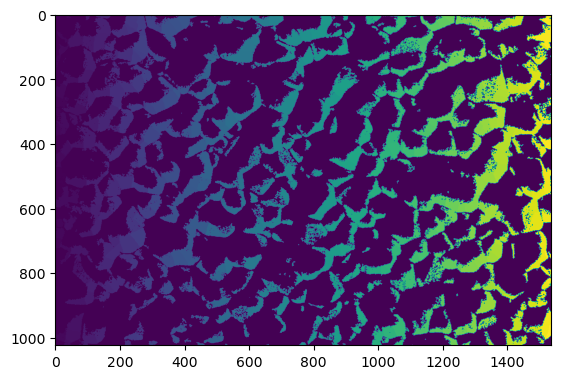

2024-03-05 14:57:48,376 - halfway_to_i2k_2023_america - INFO - Labels data has changed! Event
2024-03-05 14:57:48,382 - halfway_to_i2k_2023_america - INFO - make mask
2024-03-05 14:57:48,383 - halfway_to_i2k_2023_america - INFO - mask idx (slice(0, 1024, None), slice(0, 1536, None)), image (1024, 1536)
2024-03-05 14:57:48,384 - halfway_to_i2k_2023_america - INFO - active image shape (1024, 1536) data choice Current Displayed Region painting_data (1024, 1536) mask_idx (slice(0, 1024, None), slice(0, 1536, None))
2024-03-05 14:57:48,706 - halfway_to_i2k_2023_america - INFO - training model with labels (1024, 1536) features (1024, 1536, 9) unique labels [0 1 2]
updating model with label shape  (8893,) feature shape (8893, 9) unique labels [0 1]
2024-03-05 14:57:49,918 - halfway_to_i2k_2023_america - INFO - prediction (1536, 1024) prediction layer (1024, 1536) prediction (1024, 1536) features (1024, 1536, 9)
2024-03-05 14:57:51,914 - halfway_to_i2k_2023_america - INFO - Labels data has cha

In [ ]:
# print layers of viewer
print(viewer.layers)

# get prediction layer
result = viewer.layers[1].data[:]

result.shape, result.dtype

result[result==1] = 0

import matplotlib.pyplot as plt

plt.imshow(result)

import pyclesperanto_prototype as cle

from skimage.measure import label

labels2 = cle.voronoi_otsu_labeling(image, spot_sigma=5, outline_sigma=1)

labels = label(result)

plt.imshow(labels)
plt.imshow(labels2)

viewer.add_labels(labels)
#viewer.add_labels(labels2)

(963, 1545, 4)

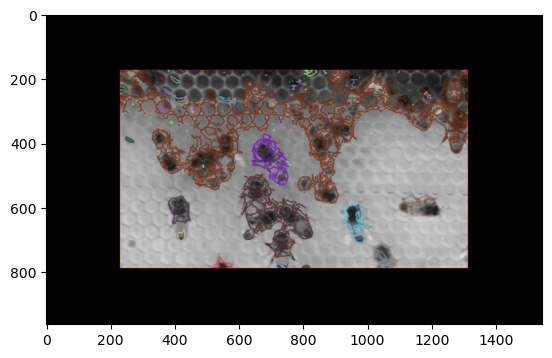

In [32]:
test2 = viewer.screenshot()
plt.imshow(test2)
test2.shape

In [20]:
type(result)
# convert to numpy array
result = result[:]
type(result)

numpy.ndarray

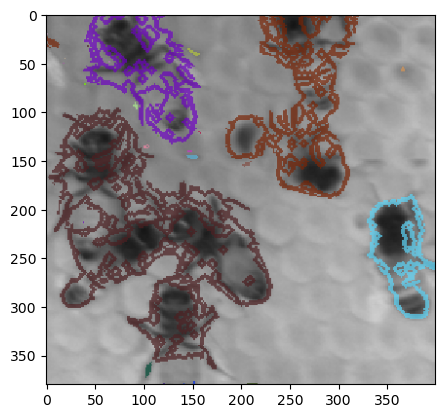

In [33]:
test3 = test2[400:780, 600:1000,:]
plt.imshow(test3)